In [1]:
import torch
# from encoder.encoders import DistributionEncoderTx
from encoder.kernel_mean import KMEEncoder
from generator.wormhole import WormholeGenerator
from datasets.mnist import MNISTDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mixer.mixer import SetMixer

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
dataset = MNISTDataset(set_size=100, n_sets=10**3, n_classes=3)
mixer = SetMixer(k=3)

In [3]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=mixer.collate_fn
)

In [4]:
enc = KMEEncoder(dataset.data[0][0].shape, d=64)

In [5]:
in_dim = 28*28
latent_dim = 64
hidden_dim = 128
set_size = dataset.set_size
device = 'cuda'

gen = WormholeGenerator(latent_dim, in_dim, hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-4)
enc.to(device)
gen.to(device)

WormholeGenerator(
  (model): DistributionDecoderTx(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SELU()
      (2): SelfAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
    (multiplier): Linear(in_features=64, out_features=6400, bias=True)
  )
  (sinkhorn): SamplesLoss()
)

In [6]:
for epoch in range(10):
    for idx,batch in enumerate(dataloader):
        
        samples = batch['samples'].to(device)
        latent = enc(samples)
        loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"epoch {epoch} batch {idx}: loss {loss.item()}")

epoch 0 batch 0: loss 563.6004638671875
epoch 0 batch 100: loss 573.16845703125
epoch 1 batch 0: loss 451.1878662109375
epoch 1 batch 100: loss 458.6114807128906
epoch 2 batch 0: loss 257.95587158203125
epoch 2 batch 100: loss 478.4242858886719
epoch 3 batch 0: loss 662.6100463867188
epoch 3 batch 100: loss 513.3933715820312
epoch 4 batch 0: loss 548.0031127929688
epoch 4 batch 100: loss 538.5498657226562
epoch 5 batch 0: loss 252.2388458251953
epoch 5 batch 100: loss 668.57080078125
epoch 6 batch 0: loss 542.3963012695312
epoch 6 batch 100: loss 332.9349365234375
epoch 7 batch 0: loss 640.2449340820312
epoch 7 batch 100: loss 578.8745727539062
epoch 8 batch 0: loss 581.9644165039062
epoch 8 batch 100: loss 594.6200561523438
epoch 9 batch 0: loss 295.52691650390625
epoch 9 batch 100: loss 470.7505187988281


[2, 2, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0]


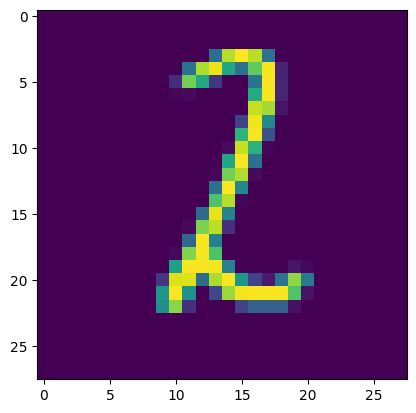

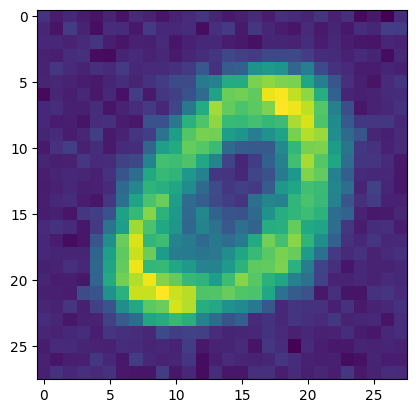

In [14]:
enc.eval()
gen.eval()

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
) # default collate now!!

with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].to(device)
        latent = enc(samples)
        img = gen(latent).reshape(32, set_size, 28, 28)
        metadata = [b.item() for b in batch['metadata'].cpu()]

        print(metadata)

        plt.imshow(samples[1][0].cpu().reshape(28, 28))
        plt.show()

        plt.imshow(img[1][0].cpu())
        break
